<a href="https://colab.research.google.com/github/clferreira1985/PUC_RJ-Pos_Ciencia_de_Dados_e_Analytics/blob/main/MVP_Sprint_2_B_Machine_Learning_e_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificador de imagens multiclasse - 10 Tipos de animais

**Contexto:** Temos um conjunto de imagens de 10 tipos de animais diferentes. O objetivo deste nottebook é criar um modelo de visão computacional que consiga classificar uma imagem dentre essas catergorias.

**Estrutura:** O notebook está dividido assim:

1. Importação das bibliotecas
2. Acesso e tratamento dos dados que serão a entrada do modelo de deep learning
3. Separação do dados de Treino e teste
4. Configuração do modelo de deep learning usando uma rede neural convolucional (CNN) simples com Keras
5. Treinamento do modelo de deep learning
6. Execução do modelo de deep learning treinado
7. Avaliação do modelo de deep learning
8. Exportação do modelo de deep learning
9. Teste do modelo exportado

**Créditos:** O notebook foi desenvolvido e documentado por:

- Cleiton Silva

**Dataset:** O dataset foi baixado do Kaggle, uma plataforma online voltada para cientistas de dados, entusiastas de aprendizado de máquina e profissionais afins. O uso é estritamente didático. Para mais informações sobre o dataset, veja o link a seguir: [animal10](https://www.kaggle.com/datasets/viratkothari/animal10).


## 1. Imports das bibliotecas necessárias para executar o notebook

In [1]:
from google.colab import drive
import gdown
from zipfile import ZipFile
import os
import pandas as pd
import numpy as np
import random
import math
import shutil
import psutil
from PIL import Image
from datetime import datetime
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers,models,Model
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight, shuffle
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import itertools
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint



## 2. Acessando e tratando os dados que serão a entrada do modelo de deep learning

As imagens estão organizadas em pastas dentro do meu google drive, então carrego as imagens de diferentes categorias em um diretório específico e crio um dataframe chamado df com as informações sobre as imagens. A coluna imagens mostrará o caminho completo para cada imagem.

In [2]:
file_id = "1Jbu196J7yqs7BcmwHfgDvWO0WuWSvH7B"

folder_path = f"https://drive.google.com/uc?id={file_id}"
output = "archive.zip"
gdown.download(folder_path, output)

Downloading...
From: https://drive.google.com/uc?id=1Jbu196J7yqs7BcmwHfgDvWO0WuWSvH7B
To: /content/archive.zip
100%|██████████| 608M/608M [00:06<00:00, 87.3MB/s]


'archive.zip'

In [3]:
with ZipFile('archive.zip', 'r') as zip_object:
  zip_object.extractall()

In [4]:
# Vamos pegar todos os arquivos dentro da pasta que armazenei todas as imagens e transformar em um dataset
%%time
path = "/content/Animals-10"
foldernames = os.listdir(path)

data = {"images": [], "animal": []}

for folder in foldernames:
    folderpath = os.path.join(path, folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["images"].append(fpath)
        data["animal"].append(folder)


df = pd.DataFrame(data)


CPU times: user 37 ms, sys: 13 ms, total: 50 ms
Wall time: 52.9 ms


In [5]:
#Vamos mudar os nomes das linhas labels, para entender melhor
translate = {"cow": "vaca",
             "horse": "cavalo",
             "butterfly": "borboleta",
             "dog": "cachorro",
             "chicken": "galinha",
             "cat": "gato",
             "elephant": "elefante",
             "sheep":"ovelha",
             "squirrel":"esquilo",
             "spider":"aranha"}

df['animal']=df['animal'].map(translate)
df['animal'].unique()


array(['ovelha', 'vaca', 'gato', 'cavalo', 'elefante', 'galinha',
       'esquilo', 'borboleta', 'cachorro', 'aranha'], dtype=object)

In [6]:
#Crio um resumo do dataset criado

print("Tamanho do dataset: ", df.shape)
print("_______________________________________")
print("Valores null: ")
print(df.isnull().sum())
print("_______________________________________")
print("Valores únicos: ")
print(df.nunique())

print("_______________________________________")
print("Qnt de imagens por categoria : ")
print(df.animal.value_counts())

print("_______________________________________")
print("Informação do dataset: ")
print(df.info())

Tamanho do dataset:  (25963, 2)
_______________________________________
Valores null: 
images    0
animal    0
dtype: int64
_______________________________________
Valores únicos: 
images    25963
animal       10
dtype: int64
_______________________________________
Qnt de imagens por categoria : 
cachorro     4863
aranha       4821
galinha      3098
cavalo       2623
borboleta    1896
vaca         1866
esquilo      1862
ovelha       1820
gato         1668
elefante     1446
Name: animal, dtype: int64
_______________________________________
Informação do dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25963 entries, 0 to 25962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  25963 non-null  object
 1   animal  25963 non-null  object
dtypes: object(2)
memory usage: 405.8+ KB
None


In [7]:
df.head()

images  animal
0   /content/Animals-10/sheep/sheep (916).jpeg  ovelha
1    /content/Animals-10/sheep/sheep (22).jpeg  ovelha
2  /content/Animals-10/sheep/sheep (1378).jpeg  ovelha
3   /content/Animals-10/sheep/sheep (179).jpeg  ovelha
4  /content/Animals-10/sheep/sheep (1314).jpeg  ovelha

<Axes: title={'center': 'Como está distribuido o dataset'}, ylabel='animal'>

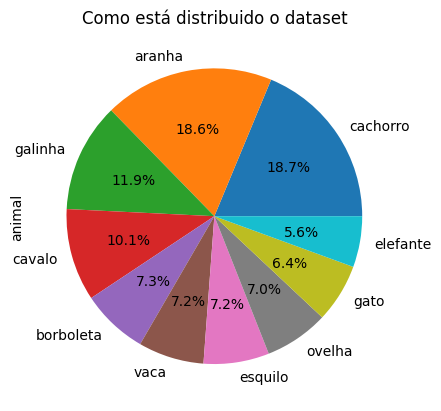

In [8]:
#Visualizando como está dividido o conjunto de dados por classe
df['animal'].value_counts().plot.pie(title='Como está distribuido o dataset', autopct='%1.1f%%')

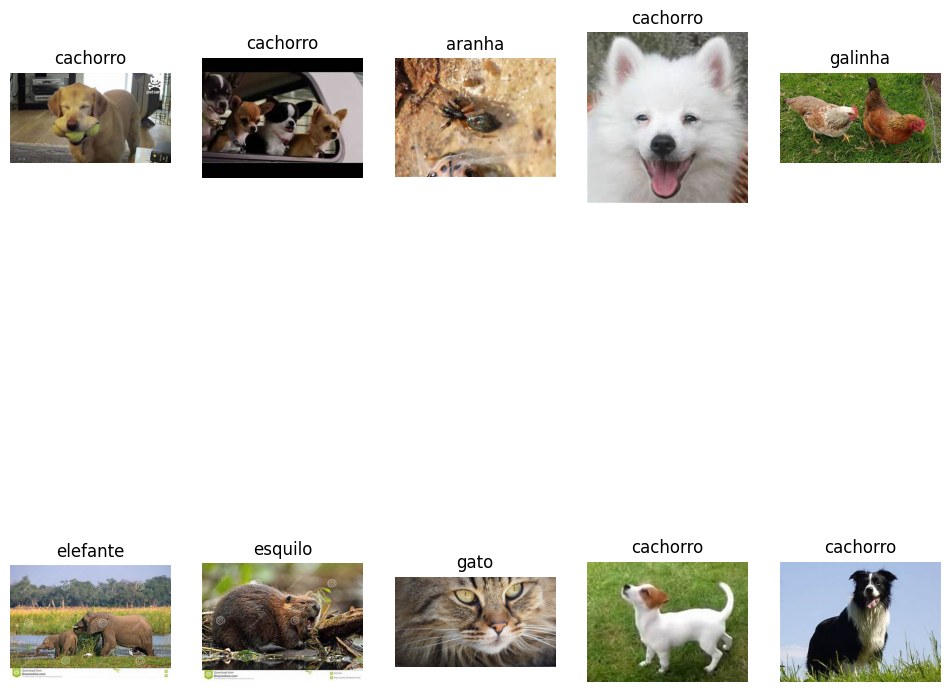

In [9]:
#visualizando algumas imagens do conjunto de dados
fig = plt.gcf()
fig.set_size_inches(3*4, 3*4)
for i, row in df.sample(n=10).reset_index().iterrows():
    plt.subplot(2,5,i+1)
    image_path = row['images']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["animal"])
    plt.axis('off')
plt.show()

## 3. Separação do dados de Treino e teste

Divisão dos dados em treino e teste: 30% das imagens para teste e 70 para treino do modelo de deep learning.

In [10]:
df_train, df_tem = train_test_split(df[['images', 'animal']].reset_index(drop=True), test_size=0.3, random_state=30, shuffle=True)
df_test, df_val = train_test_split(df_tem, test_size=0.6, random_state=30, shuffle=True)



In [11]:
#Resumo da separação do conjunto de dados
print("#########Train##############")
print(df_train.head())
print(df_train.shape)
print("#########Test###############")
print(df_test.head())
print(df_test.shape)
print("#########Validação###############")
print(df_val.head())
print(df_val.shape)

#########Train##############
                                                  images     animal
15322  /content/Animals-10/butterfly/butterfly (343).jpg  borboleta
10670    /content/Animals-10/chicken/chicken (2088).jpeg    galinha
5568          /content/Animals-10/horse/horse (383).jpeg     cavalo
3638              /content/Animals-10/cow/cow (516).jpeg       vaca
11881     /content/Animals-10/chicken/chicken (353).jpeg    galinha
(18174, 2)
#########Test###############
                                              images    animal
6305     /content/Animals-10/horse/horse (2278).jpeg    cavalo
23919  /content/Animals-10/spider/spider (3192).jpeg    aranha
4679           /content/Animals-10/cat/cat (49).jpeg      gato
25679  /content/Animals-10/spider/spider (1497).jpeg    aranha
16542         /content/Animals-10/dog/dog (138).jpeg  cachorro
(3115, 2)
#########Validação###############
                                                 images    animal
7978   /content/Animals-10/elephant

#### Preparação dos dados



Através da classe **ImageDataGenerator** do TensorFlow iremos configurar geradores de dados para o treinamento, validação, e teste

In [12]:
%%time

BATCH_SIZE = 20 #Defino o tamanho do lote
IMAGE_SIZE = (150, 150) #Defino o tamanho das imagens

train_datagen=ImageDataGenerator(rescale=1./255,
                             rotation_range=40,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)
val_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=df_train,
    target_size= IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    x_col='images',
    y_col='animal',
    color_mode ='rgb',
    seed = 20,
    shuffle=False
    )

val_generator=val_datagen.flow_from_dataframe(
    dataframe=df_val,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    x_col='images',
    y_col='animal',
    color_mode ='rgb',
    shuffle=False
    )

test_generator=test_datagen.flow_from_dataframe(
    dataframe = df_test,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    x_col='images',
    y_col='animal',
    color_mode ='rgb',
    shuffle=False)

Found 18174 validated image filenames belonging to 10 classes.
Found 4674 validated image filenames belonging to 10 classes.
Found 3115 validated image filenames belonging to 10 classes.
CPU times: user 143 ms, sys: 54.8 ms, total: 198 ms
Wall time: 197 ms


Found 1 validated image filenames belonging to 1 classes.


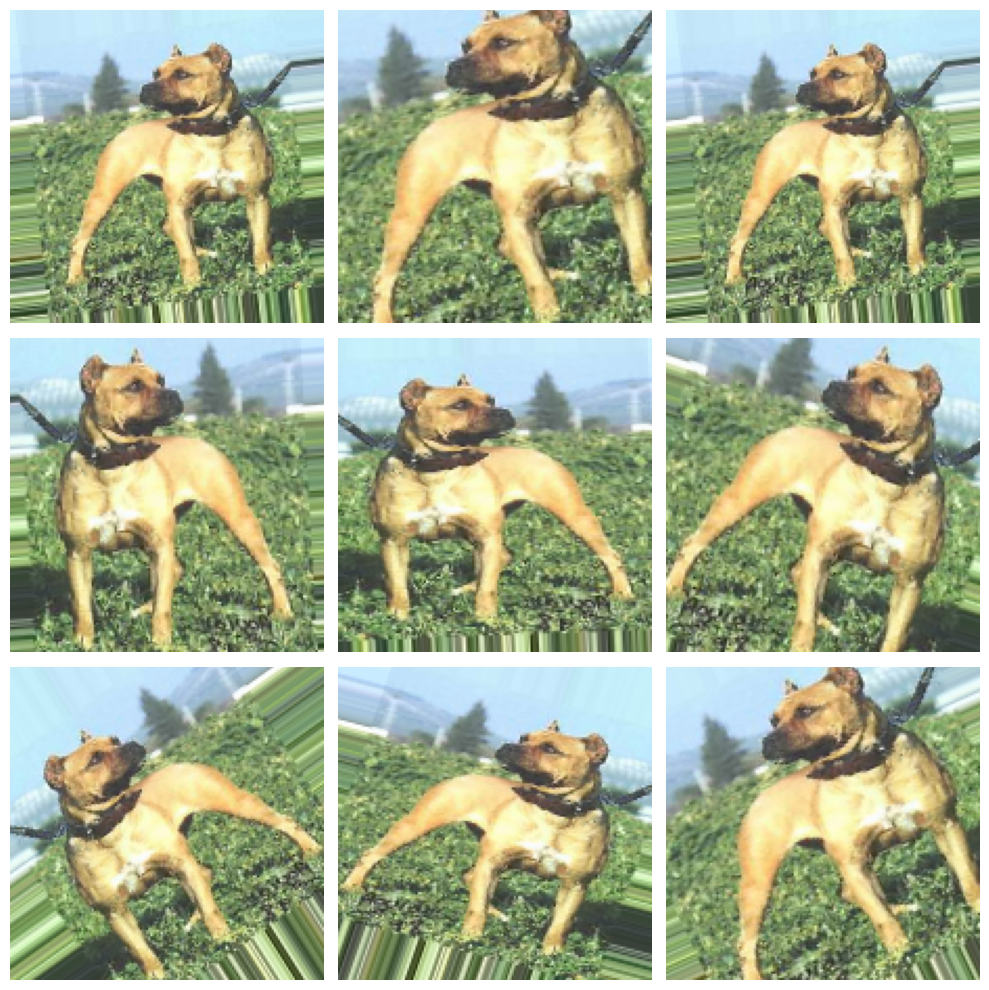

In [13]:
#Visualizo uma imagem com o class_mode="categorical"
sample = df.sample(n=1)

sample_generator = train_datagen.flow_from_dataframe(
    dataframe = sample,
    x_col='images',
    y_col='animal',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    color_mode ='rgb',
)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in sample_generator:
        image = x_batch[0]
        plt.imshow(image)
        plt.axis('Off')
        break
plt.tight_layout()
plt.show()

## 4. Configuração de um modelo de deep learning usando uma rede neural convolucional (CNN)



In [ ]:
#num_classes = len(set(train_generator.classes))

#Data Augmentation Step
#augment = tf.keras.Sequential()

#inputs = layers.Input(shape=(150, 150, 3), name='inputLayer')
#x = augment(inputs)
#x = layers.Conv2D(64, (3, 3), activation='relu')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(128, (3, 3), activation='relu')(x)
#x = layers.BatchNormalization()(x)
#x = layers.MaxPooling2D((2, 2))(x)

#x = layers.Flatten()(x)
#x = layers.Dropout(0.25)(x)
#x = layers.Dense(128, activation='relu')(x)
#x = layers.BatchNormalization()(x)
#x = layers.Dropout(0.25)(x)
#x = layers.Dense(num_classes, activation='softmax')(x)
#outputs = x

#model = Model(inputs=inputs, outputs=outputs)

#print(model.summary())


Depois de testar o modelo acima, resolvi utilizar o modelos abaixo.

O modelo VGG16 é um modelo pré treino, nesse modelo adiciono os seguintes argumentos:



*   include_top = False - False porque não quero as 3 primeiras camadas conctadas, no topo da rede, pois irei adicionar uma camada de classificação posterior.

*   weights = 'imagenet' - Especifico que quero utilizar os pesos pré-treinados do modelo

Em seguida congelo as 4 ultimas camadas, isso significa que elas não serão treinadas. Ao fazer isso, evito que os pesos pré-treinados sejam ajustados.

Finalizo combinando o modelo pré-treinado com a camada personalizada.



In [14]:
#modelo VGG16

img_size = 150
model = VGG16(include_top = False,
                  weights = 'imagenet',
                  input_shape = (img_size, img_size, 3))
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [15]:
model.layers

for layer in model.layers[:-4]:
    layer.trainable = False

x = layers.Flatten()(model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(10, activation='softmax')(x)
model = Model(model.input, x)


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## 5. Treinamento do modelo de deep learning

O código abaixo irá compilar o modelo usando o otimizador Adam com de aprendizado de 0.0001. Como tenho um dataset com mais de 10 categorias, utilizo a função de perda como "categorical_crossentropy".


Em seguida, crio um modelo de treinamento com 30 epochs e defino o comprimento com o tamanho de train generator e val generator.

Dois callbacks serão utlizados durante o treinamento:

O EarlyStopping monitora a perda de validação (val_loss) e interrompe o treinamento caso a perda não melhore após 5 épocas.

O ReduceLROnPlateau monitora a perda de validação (val_loss) e reduz a taxa de aprendizado em 0.2 caso a perda não melhore após 2 épocas.

In [16]:
%%time

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


CPU times: user 13.6 ms, sys: 178 µs, total: 13.8 ms
Wall time: 13.1 ms


In [17]:
%%time

history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=30,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True), #Monitoro val_loss e interrompo o treinamento caso a métrica não melhore em 5 epochs
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min'), #Monitoto val_loss e reduzo a taxa de aprendizado em 0.2 quando a métrica fica estagnada
                              ]
)

Epoch 1/15
909/909 [==============================] - 156s 156ms/step - loss: 0.9282 - accuracy: 0.6925 - val_loss: 0.6244 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 2/15
909/909 [==============================] - 140s 154ms/step - loss: 0.5976 - accuracy: 0.8064 - val_loss: 0.5419 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 3/15
909/909 [==============================] - 139s 153ms/step - loss: 0.4856 - accuracy: 0.8460 - val_loss: 0.4298 - val_accuracy: 0.8639 - lr: 1.0000e-04
Epoch 4/15
909/909 [==============================] - 141s 155ms/step - loss: 0.4176 - accuracy: 0.8623 - val_loss: 0.4523 - val_accuracy: 0.8577 - lr: 1.0000e-04
Epoch 5/15
909/909 [==============================] - 141s 155ms/step - loss: 0.3616 - accuracy: 0.8821 - val_loss: 0.4754 - val_accuracy: 0.8539 - lr: 1.0000e-04
Epoch 6/15
909/909 [==============================] - 140s 154ms/step - loss: 0.2277 - accuracy: 0.9297 - val_loss: 0.3069 - val_accuracy: 0.9029 - lr: 2.0000e-05
Epoch 7/15
909/909 [==

### Exibo o desempenho do modelo

Crio um código para visualiza a evolução da perda e acurácia ao longo das épocas durante o treinamento e validação do modelo. Isso permitirá uma análise visual do desempenho do modelo e ajuda a identificar possíveis problemas, como overfitting ou underfitting.

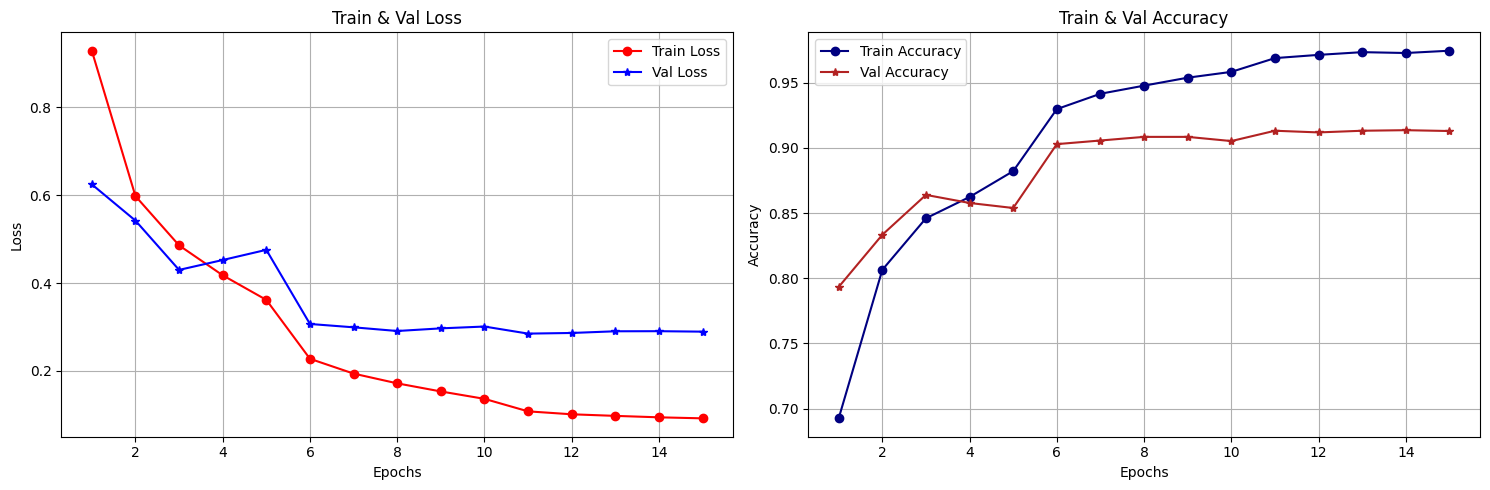

In [18]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

epochs = range(1, len(history.history['accuracy']) + 1)
loss_vals = history.history['loss']
val_loss_vals = history.history['val_loss']
acc_vals = history.history['accuracy']
val_acc_vals = history.history['val_accuracy']

ax[0].plot(epochs, loss_vals, color='red', marker='o', linestyle='-', label='Train Loss')
ax[0].plot(epochs, val_loss_vals, color='blue', marker='*', linestyle='-', label='Val Loss')
ax[0].set(title='Train & Val Loss', xlabel='Epochs', ylabel='Loss')
ax[0].legend(loc='best')
ax[0].grid(True)

ax[1].plot(epochs, acc_vals, color='navy', marker='o', linestyle='-', label='Train Accuracy')
ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', linestyle='-', label='Val Accuracy')
ax[1].set(title='Train & Val Accuracy', xlabel='Epochs', ylabel='Accuracy')
ax[1].legend(loc='best')
ax[1].grid(True)

plt.tight_layout()
plt.show()

#### Previsões

Crio um DataFrame chamado Predictions com as informações de previsão do modelo. O DataFrame terá as seguintes colunas:

*   "Image Index": Índice da imagem no conjunto de teste
*   "Test Labels": Rótulos reais das imagens no conjunto de teste
*   "Test Classes": Classes correspondentes aos rótulos reais
*   "Prediction Labels": Rótulos previstos pelo modelo
*   "Prediction Classes": Classes correspondentes aos rótulos previstos
*   "Path": Caminho dos arquivos de imagem
*   "Prediction Probability": Probabilidade da classe prevista pelo modelo

In [19]:
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

classes = dict(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index": list(range(len(test_generator.labels))),
                            "Test Labels": test_generator.labels,
                            "Test Classes": [classes[i] for i in test_generator.labels],
                            "Prediction Labels": y_pred,
                            "Prediction Classes": [classes[i] for i in y_pred],
                            "Path": test_generator.filepaths,
                            "Prediction Probability": [x for x in np.asarray(np.max(model.predict(test_generator), axis=1))]
                           })
Predictions.head(10)

156/156 [==============================] - 11s 69ms/step


Image Index  Test Labels Test Classes  Prediction Labels  \
0            0            3       cavalo                  3   
1            1            0       aranha                  0   
2            2            7         gato                  7   
3            3            0       aranha                  1   
4            4            2     cachorro                  2   
5            5            1    borboleta                  1   
6            6            1    borboleta                  1   
7            7            2     cachorro                  2   
8            8            2     cachorro                  2   
9            9            2     cachorro                  2   

  Prediction Classes                                               Path  \
0             cavalo        /content/Animals-10/horse/horse (2278).jpeg   
1             aranha      /content/Animals-10/spider/spider (3192).jpeg   
2               gato              /content/Animals-10/cat/cat (49).jpeg   
3          borboleta      /content/Animals-10/spider/spider (1497).jpeg   
4           cachorro             /content/Animals-10/dog/dog (138).jpeg   
5          borboleta  /content/Animals-10/butterfly/butterfly (234)....   
6          borboleta  /content/Animals-10/butterfly/butterfly (743)....   
7           cachorro            /content/Animals-10/dog/dog (4766).jpeg   
8           cachorro            /content/Animals-10/dog/dog (3186).jpeg   
9           cachorro            /content/Animals-10/dog/dog (1070).jpeg   

   Prediction Probability  
0                0.999787  
1                0.845051  
2                0.999066  
3                0.908235  
4                0.865074  
5                0.860111  
6                0.996680  
7                0.999665  
8                0.999885  
9                0.999590

## 6. Execução do modelo treinado em um subconjunto das imagems de teste com as previsões vinculadas


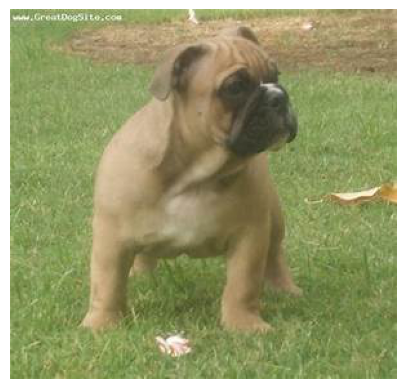

True Label:  cachorro
Predicted Label:  cachorro
Probability:  1.0



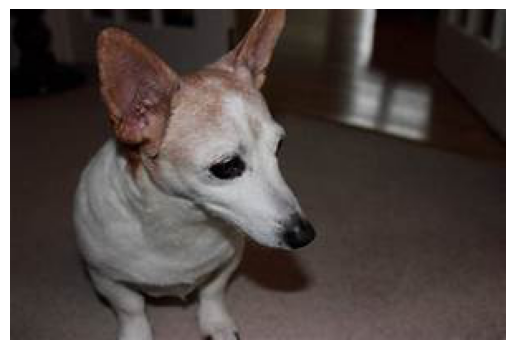

True Label:  cachorro
Predicted Label:  cavalo
Probability:  0.8



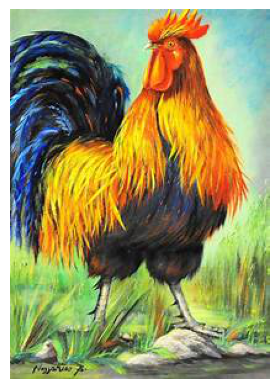

True Label:  galinha
Predicted Label:  galinha
Probability:  1.0



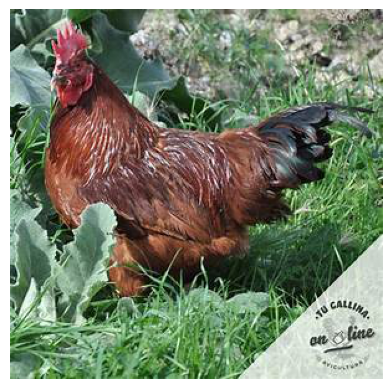

True Label:  galinha
Predicted Label:  galinha
Probability:  1.0



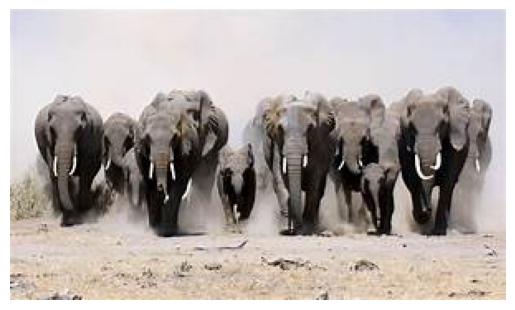

True Label:  elefante
Predicted Label:  elefante
Probability:  0.96



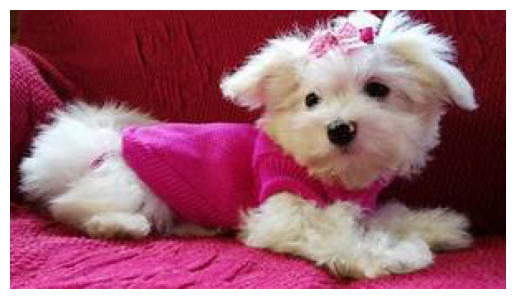

True Label:  cachorro
Predicted Label:  cachorro
Probability:  0.99



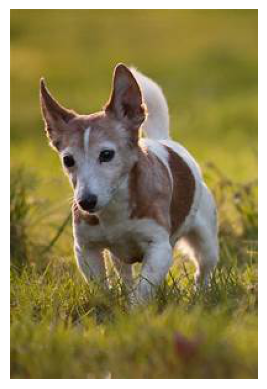

True Label:  cachorro
Predicted Label:  cachorro
Probability:  0.87



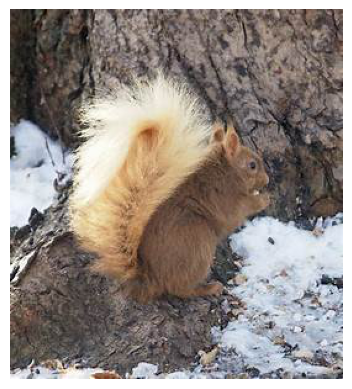

True Label:  esquilo
Predicted Label:  esquilo
Probability:  0.5



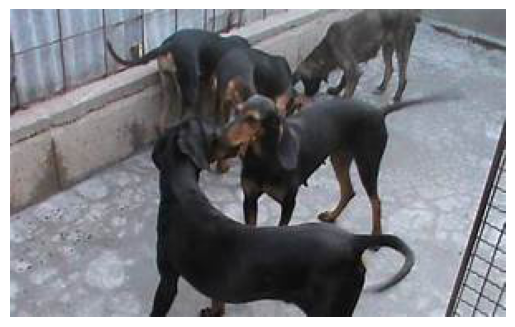

True Label:  cachorro
Predicted Label:  cavalo
Probability:  0.36



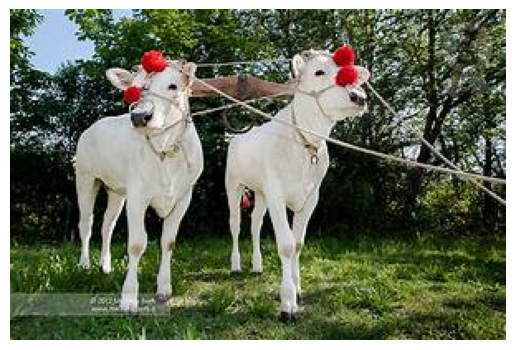

True Label:  vaca
Predicted Label:  galinha
Probability:  0.67



In [20]:
# Obtendo uma amostra aleatória de 10 linhas do DataFrame Predict

sample_predictions = Predictions.sample(n=10)

for index, row in sample_predictions.iterrows():
    # Obtendo as informações necessárias para visualização e impressão
    image = plt.imread(row['Path'])
    true_label = row['Test Classes']
    predicted_label = row['Prediction Classes']
    probability = row['Prediction Probability']

    # Arredondando a probabilidade para duas casas decimais
    probability = round(probability, 2)

    # Configuração da figura para exibir a imagem
    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Impressão dos resultados da classificação
    print("True Label: ", true_label)
    print("Predicted Label: ", predicted_label)
    print("Probability: ", probability)
    print()

## 7. Avaliação do modelo de deep learning


In [21]:
results = model.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.2f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.29
Test Accuracy: 91.78%


In [22]:
accuracy = skm.accuracy_score(y_true, y_pred)
precision = skm.precision_score(y_true, y_pred, average='weighted')
recall = skm.recall_score(y_true, y_pred, average='weighted')
f1score = skm.f1_score(y_true, y_pred, average='weighted')

# Arredondar os valores para duas casas decimais
accuracy = round(accuracy, 2)
precision = round(precision, 2)
recall = round(recall, 2)
f1score = round(f1score, 2)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1score)
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1 Score: 0.92
              precision    recall  f1-score   support

      aranha       0.98      0.96      0.97       596
   borboleta       0.93      0.98      0.95       208
    cachorro       0.94      0.91      0.93       588
      cavalo       0.91      0.92      0.92       308
    elefante       0.86      0.90      0.88       160
     esquilo       0.90      0.88      0.89       223
     galinha       0.93      0.96      0.95       376
        gato       0.85      0.84      0.84       217
      ovelha       0.84      0.89      0.86       219
        vaca       0.87      0.85      0.86       220

    accuracy                           0.92      3115
   macro avg       0.90      0.91      0.90      3115
weighted avg       0.92      0.92      0.92      3115



Matriz de confusão sem normalização


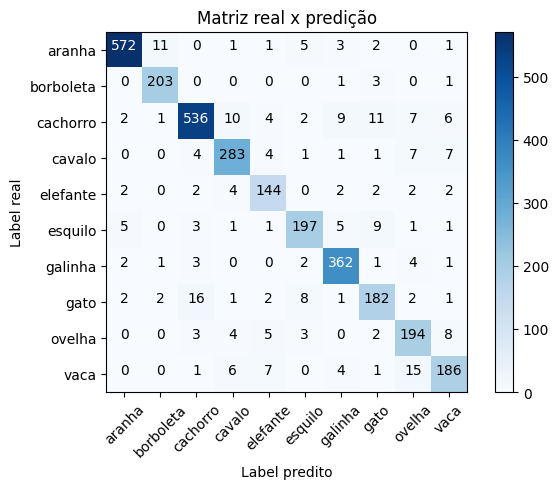

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    A normalização pode ser aplicada definindo `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão sem normalização')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt_str = '{:d}' if not normalize else '{:.2f}'

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt_str.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Label real')
    plt.xlabel('Label predito')

class_names = list(test_generator.class_indices.values())
y_pred = Predictions['Prediction Labels']
y_test = Predictions['Test Labels']
Map_class = test_generator.class_indices

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=Map_class,
                      normalize=False,
                      title='Matriz real x predição')

## 8. Exportação do modelo de deep learning para posterior uso

Salvando o modelo de deep learning que foi treinado em uma pasta no meu google drive

In [24]:
# obtendo a data e hora atual
now = datetime.now()

# Definição do formato
format = '%Y-%m-%dT%H%M'

# Converter a data e hora em uma string com o formato especificado
formatted_datetime = now.strftime(format)

path_model = '/content/'

name_model = 'trained_model_animal10' + formatted_datetime + '.h5'

# salvando o modelo
model.save("%s/%s" % (path_model, name_model))
print("Modelo salvo com o nome: ", name_model)

Modelo salvo com o nome:  trained_model_animal102023-07-20T2001.h5


## 9. Teste do modelo exportado

O projeto pode ter dois formas de obter o resultado, o primeiro se o projeto for rodado todo do inicio ao fim; O segundo é utilizando o modelo já carregado, para isso você vai precisar tirar os comentários do código abaixo.



In [ ]:
#file_id_model = "1HOEuLSP2U8mUbxr27F4aCGquPbqEdTmR"
#folder_path_model = f"https://drive.google.com/uc?id={file_id_model}"
#output_model = "model.h5"
#gdown.download(folder_path_model, output_model)
#path_model2 = "/content/"
#loaded_model = keras.models.load_model("%s/%s" % (path_model2, output_model))
#print("Modelo %s carregado com sucesso" % (name_model))

In [25]:
loaded_model = keras.models.load_model("%s/%s" % (path_model, name_model))
print("Modelo %s carregado com sucesso" % (name_model))

Modelo trained_model_animal102023-07-20T2001.h5 carregado com sucesso


In [26]:
y_true = test_generator.classes
y_pred = np.argmax(loaded_model.predict(test_generator), axis = 1)

classes = dict(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index": list(range(len(test_generator.labels))),
                            "Test Labels": test_generator.labels,
                            "Test Classes": [classes[i] for i in test_generator.labels],
                            "Prediction Labels": y_pred,
                            "Prediction Classes": [classes[i] for i in y_pred],
                            "Path": test_generator.filepaths,
                            "Prediction Probability": [x for x in np.asarray(np.max(loaded_model.predict(test_generator), axis=1))]
                           })
Predictions.head(10)


156/156 [==============================] - 11s 72ms/step


Image Index  Test Labels Test Classes  Prediction Labels  \
0            0            3       cavalo                  3   
1            1            0       aranha                  0   
2            2            7         gato                  7   
3            3            0       aranha                  1   
4            4            2     cachorro                  2   
5            5            1    borboleta                  1   
6            6            1    borboleta                  1   
7            7            2     cachorro                  2   
8            8            2     cachorro                  2   
9            9            2     cachorro                  2   

  Prediction Classes                                               Path  \
0             cavalo        /content/Animals-10/horse/horse (2278).jpeg   
1             aranha      /content/Animals-10/spider/spider (3192).jpeg   
2               gato              /content/Animals-10/cat/cat (49).jpeg   
3          borboleta      /content/Animals-10/spider/spider (1497).jpeg   
4           cachorro             /content/Animals-10/dog/dog (138).jpeg   
5          borboleta  /content/Animals-10/butterfly/butterfly (234)....   
6          borboleta  /content/Animals-10/butterfly/butterfly (743)....   
7           cachorro            /content/Animals-10/dog/dog (4766).jpeg   
8           cachorro            /content/Animals-10/dog/dog (3186).jpeg   
9           cachorro            /content/Animals-10/dog/dog (1070).jpeg   

   Prediction Probability  
0                0.999787  
1                0.845051  
2                0.999066  
3                0.908235  
4                0.865074  
5                0.860111  
6                0.996680  
7                0.999665  
8                0.999885  
9                0.999590

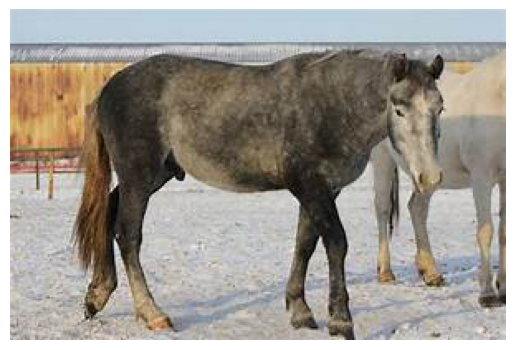

True Label:  cavalo
Predicted Label:  cavalo
Probability:  0.97



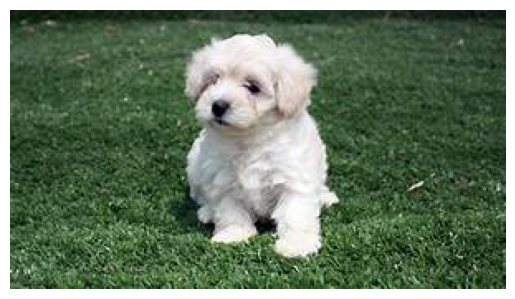

True Label:  cachorro
Predicted Label:  cachorro
Probability:  1.0



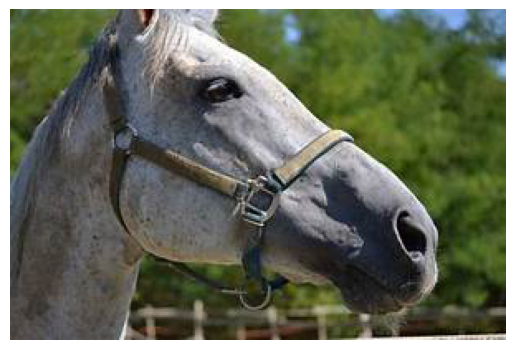

True Label:  cavalo
Predicted Label:  cavalo
Probability:  1.0



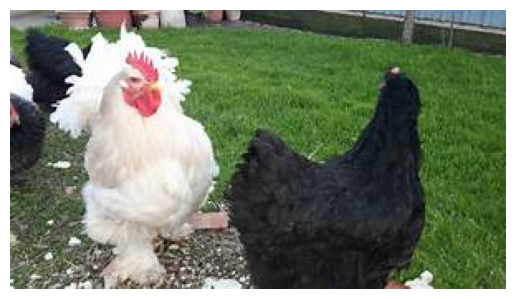

True Label:  galinha
Predicted Label:  galinha
Probability:  1.0



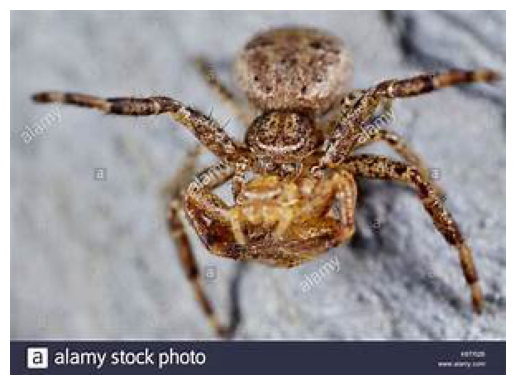

True Label:  aranha
Predicted Label:  aranha
Probability:  1.0



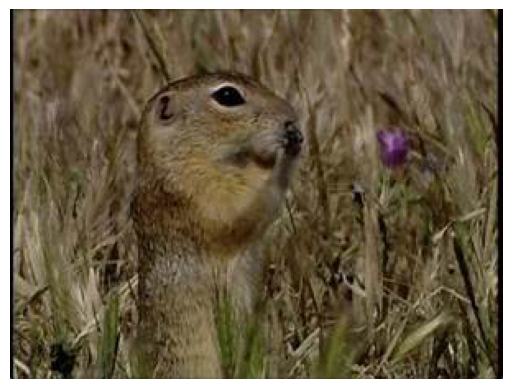

True Label:  esquilo
Predicted Label:  esquilo
Probability:  1.0



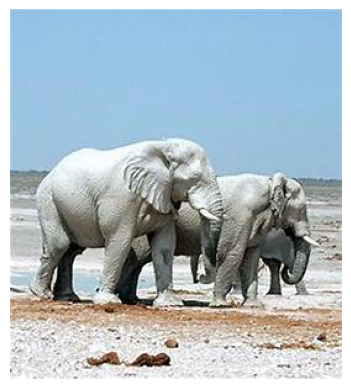

True Label:  elefante
Predicted Label:  elefante
Probability:  1.0



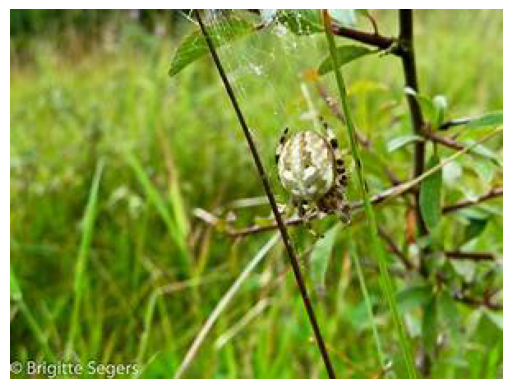

True Label:  aranha
Predicted Label:  aranha
Probability:  0.51



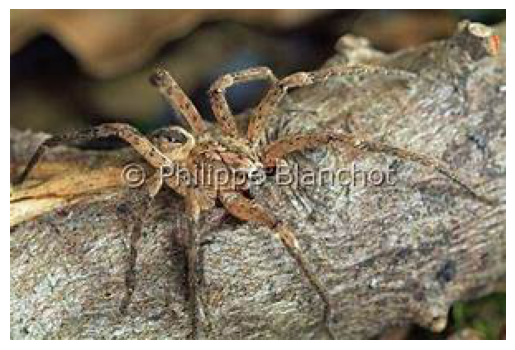

True Label:  aranha
Predicted Label:  aranha
Probability:  1.0



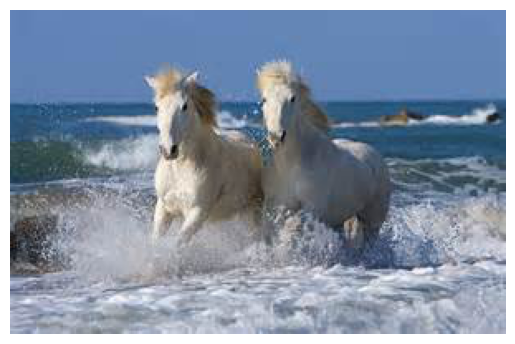

True Label:  cavalo
Predicted Label:  cavalo
Probability:  0.88



In [27]:
sample_predictions = Predictions.sample(n=10)

for index, row in sample_predictions.iterrows():
    # Obtendo as informações necessárias para visualização e impressão
    image = plt.imread(row['Path'])
    true_label = row['Test Classes']
    predicted_label = row['Prediction Classes']
    probability = row['Prediction Probability']

    # Arredondando a probabilidade para duas casas decimais
    probability = round(probability, 2)

    # Configuração da figura para exibir a imagem
    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Impressão dos resultados da classificação
    print("True Label: ", true_label)
    print("Predicted Label: ", predicted_label)
    print("Probability: ", probability)
    print()

##10. Relatório Final

De início utilizei um modelo personalizado mais simples, observei que mesmo buscando fazer ajustes na arquitetura, no batch, taxa de aprendizado, épocas e tamanho de steps o modelo chegou no máximo 0,68 de desempenho.

Depois de algumas tentativas de melhorar o modelo resolvi testar o modelo VGG16, por ser uma arquitetura pré-treinada. Apresentou um erro de incompatibilidade, um dos motivos era as classes de saída, então combinei o modelo pré-treinado com a camada personalizada. Essa modificação deixou meu modelo com uma taxa de acerto maior. Vale ressaltar que a taxa de aprendizado, batchs etc foram mantidos com base na melhor acurácia do modelo personalizado. Como o modelo estava performando melhor, resolvi testar congelando as 4 últimas camadas. O desempenho não teve tanta diferença, então optei em não alterar mais o projeto.   
